# Catalogs in IBIS/ISGRI

ISGRI spectral and lightcurve extraction uses a `isgri_srcl_res.fits` catalog result.
The nominal way to get the `isgri_srcl_res.fits` is by running the mosaic (see the [User Guide](https://www.isdc.unige.ch/integral/)). Of course, it is possible to fudge any other catalog in the necessary format (this is done in [MMODA](https://www.astro.unige.ch/mmoda/) when a catalog is generated from json provided by frontend or API), but this fudging is not naturally supported by `OSA` and should be done with a lot of care.

**The reason why the mosaic is need before spectrum** in standard user workflow in OSA is because the spectral extraction quality depends strongly on the catalog - the sky model used for deconstructing the shadowgram. With a wrong catalog, unaccounted source counts will be misattributed to other sources (distorting them) and to background. Due to wide PSFs, sources in some positions overlap substantially. 

Larger part of this note quantifies this effect of "cross-talk" between source counts. Specifically, we will show flux of anysource-of-interest (`SOI`) is modified by unaccounted source flux typically by a fraction of the source count rate, depending on position of both sources. 

## MURA Mask

ISGRI mask has `MURA` pattern (see [doc](https://www.isdc.unige.ch/integral/download/osa/doc/11.2/osa_um_ibis.pdf) and [paper](https://arxiv.org/pdf/astro-ph/0311172.pdf)), whos cyclic autocorrelation is a $\delta$ function. This does not mean, however, that PSF is a $\delta$ function, as it is modified by a several effects. Most of all, within a limited FoV, the auto-correlation develops side-peaks and other symmetric features (they appear as "ghosts"). The FoV is effectively further modified by uneven detector efficiency in FoV. In PCFoV, the effect is no more contained to single dots/lines, largely due to interplay with background: since PIFs do not fill the entire detector anymore, while background still does, the PIFs are much more importantly correlated. Somewhat uncertain and variable background shape creates a further complication.

```{note}
Notably, Swift/BAT and even SVON/ECLAIR do not use MURA mask, and opt for a quasi-random pattern. It may be argued what is actually better: compressing the systematic noise in well-understood regions of data space, or spreading in quasi-randomly. 

Consider how GW detectors compress the noise in resonances, improving the sensitivity elsewhere. 

Clearly, if the location and properties of the regions where the noise is concentrated is poorly understood, the complication is reconstructed.

Another difficulty is that concentrated noise makes some regions largely unaccessible to scientific analysis. If the regions can be moved in different observations, this challenge can be alleviated - this is done in INTEGRAL.
```

One on of the consequences of MURA pattern is that on-axis source is not strongly modified by unaccounted source flux, except if the source is in the PSF side-lobes, which do not occupy large area. So even if at the main PSF side-peak, the contaminating count rate is about 50% of the source, the chance of this event is not large. However, since the PSF orientation depends on the pointing orientation, the PSF overlap occurs very often, resulting in modest average effect.

```{figure} catalog-study/I0_J0_C100_Cm100_B1000.png
:height: 250px
:width: 600px
:name: fig1

On-axis 100cps source contaminated by unaccounted 100cps source in different locations. 80 pixels per 15 deg.
```


```{figure} catalog-study/I40_J40_C100_Cm100_B1000.png
:height: 250px
:width: 600px
:name: figure-example

Somewhat off-axis (7,7 deg) 100cps source contaminated by unaccounted 100cps source in different locations.
```


```{figure} catalog-study/I20_J20_C100_Cm100_B1000.png
:height: 250px
:width: 600px
:name: figure-example

Very slightly off-axis (3.5,3.5 deg) 100cps source contaminated by unaccounted 100cps source in different locations.
```



```{note}
Note that in spectral/lightcurve extraction the contamination is not the same as in imaging. Imaging uses iterative process, leading to different distribution of fluxes between correlated sources depending on both source count rate and significance. Spectral/lightcurve countrates produce more accurate count rates since they perform global fit.  We will only focus on spectra/lightcurves here. In principle, these fluxes also allow to reconstruct the image better, though this is not easy to implement in OSA.

Notably, in spectral-ligthcurve count rate extraction, the contamination fraction does not depend on source intensities.

When source counts are distributed over multiple known sources, the situation is more difficult to quantify simply.
``` 


## Different input catalogs

The good catalog also allows to produce image - so the process is iterative (image -> catalog -> image -> catalog ... -> catalog -> spectra/lc ). This is the major source of complexity for coded mask analysis (and not only, this applies for every instrument with complex PSF, e.g. Fermi/LAT, or SKA).

**INTEGRAL General Reference Catalog** (`GENREFCAT`) is the best global catalog for INTEGRAL,  with source fluxes indicated, but it is not time-dependent. 
Using only `GENREFCAT` one often has too many sources in a particular observation catalog, and would miss some sources which are only detectable in short outbursts.
Using too many sources in OSA causes issues, since fitting may not converge and/or fail in other ways. In general up to 200 sources can be treated safely.

So, it is always advisable to produce an catalog *dedicated* to the observation of interest. 

**In the simplest case**, when running spectral extraction directly in one ScW pipeline but it will only rely on the general reference catalog and imaging of *this one ScW*. This works at minimum, but this is *not recommended* even at the typical observer level.

We'd need a **time-dependent catalog** with all sources accounted on all timescales from ScW at least to whole mission. To be clear, to account for all sources, it is necessary to have intermediate timescales (hour, orbit, year, etc). The durations depend on the required systematic noise, which is typically related to statistical sensitivity. So the required timescales depend on the total exposure.
But it should be clear that this is in principle a large task, that's why so much effort goes in production of INTEGRAL catalog papers. The best approximations of this approach are used in different pipelines by different teams.


## Building the best sufficient input catalog

At the **legacy stage**, with the large data collection available now, we can provide the "recommended good" catalogs for spectral/lightcurve extraction at any time.

Notably, this catalog **does not need to include every detectable source**. As shown in the analysis below, most of the time contaimination from missing sources is about 10% in average.
For in a region of 1-sigma sensitivity of 0.1 mCrab (achievable in about 3Ms), only sources brigther than 3mCrab will contribute more than 3 sigma to the SOI flux.
3 mCrab sources are detectable (S/N 5) in a much smaller exposure of about 80ks - a typical observation in an orbit. So to achieve the current goal, it is **not necessary to build whole-mission catalog**, but **it is roughly sufficient to make mosaics in different observations of each revolution**. However, to get sufficient systematic uncertainty for weaker sources, larger timescales are required.

Even though Spectral/lightcurve information might not be very useful for sources which are not detected significantly enough in multiple spectral/time bins, weaker sources can make a significant (detectable) difference to the source fluxes and spectral shape.

The systematic uncertainty from unaccounted sources can be also compared to the systematic uncertainty of ISGRI flux calibration - 1% or 1mCrab for 100mCrab source. The same effect can be created by a 10mCrab unaccounted source - the kind of source which can also be found in 1-orbit observations.

```{note}
The recommended maximal timescale of the input catalog depends on the total exposure in the region of interest, and is a fraction of this exposure, in a given simple example - 2% of it (we can expect something similar in general). So the maximal typical timescale is about a month, but one orbit is sufficient for sources in 3Ms field.
```

The result of such an analysis count be an extension of GENREFCAT but with indication of time validity of each flux record measurement. If put in a single catalog, it would have millions of rows. This is best handled in a relational DB.

Ultimately, it is better to see the goal in designing a procedure for producing a catalog for given observation. The catalog can be built by querying the collection of available mosaics and providing the current best guess. The collection would have some 20k rows, and can be queried from an available store.


In [3]:
# adopted from  https://renkulab.io/projects/vladimir.savchenko/integral-ref-cat/files/blob/catsearch.ipynb



import numpy as np
import astropy
import astropy.coordinates

cat = astropy.io.fits.open("http://isdcarc.unige.ch/arc/rev_3/cat/hec/gnrl_refr_cat_0043.fits")
cat_table = cat[1].data
cat_coord = astropy.coordinates.SkyCoord(cat[1].data['RA_OBJ'], cat[1].data['DEC_OBJ'], unit='deg')

len(cat_table)

2410

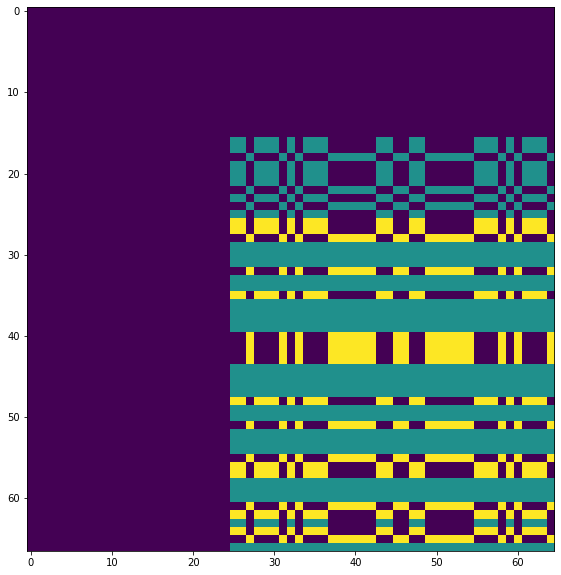

In [9]:
maskmod = astropy.io.fits.open("http://isdcarc.unige.ch/arc/rev_3/ic/ibis/mod/isgr_mask_mod_0004.fits")

from matplotlib import pylab as plt

maskmap = maskmod[1].data

def pif(src_i, src_j):
    m = np.zeros_like(maskmap)
    m[src_i:,src_j:] = maskmap[:m.shape[0] - src_i,:m.shape[1] - src_j]
    # m[int(m.shape[0]/2-134/2/2):int(m.shape[0]/2+134/2/2), int(m.shape[1]/2-130/2/2):int(m.shape[1]/2+130/2/2)] += 1
    return m[int(m.shape[0]/2-134/2/2):int(m.shape[0]/2+134/2/2), int(m.shape[1]/2-130/2/2):int(m.shape[1]/2+130/2/2)]


plt.figure(figsize=(10,10))

deg_in_px = 15./80

# plt.imshow(maskmap)
# plt.imshow(pif(0, int(15/deg_in_px)) )
# plt.imshow(pif(0,int(3/deg_in_px)) )
plt.imshow(pif(30,40) + pif(40, 40) )

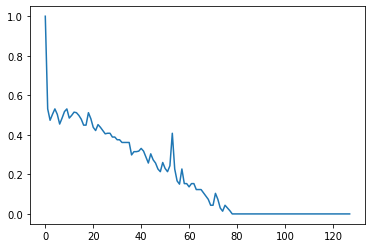

In [21]:
c = []

p1 = pif(0,0)

for i in range(128):
    p2 = pif(0,i)

    c.append(np.sum(p1 * p2) / np.sum(p1**2))
    
plt.figure()

plt.plot(c)

In [20]:
I, J = 20, 20
C = 100
Cm = 100
B = 1000


import time
import scipy
import scipy.stats

def sky_model(i_j_counts, bkg_const):
    model = np.zeros_like(pif(0,0)) + bkg_const

    for i, j, c in i_j_counts:
        model += c*pif(i, j)

    return model

def sky_realization(i_j_counts, bkg_const):    
    return scipy.stats.poisson.rvs(sky_model(i_j_counts, bkg_const))

def sky_reconstruction(i_j_counts, bkg_const, i_j_counts_model):
    sky = sky_realization(i_j_counts, bkg_const)

    def m2LL(reconstructed_counts):
        # print("try", reconstructed_counts)
        return -2*np.sum(scipy.stats.poisson.logpmf(
            sky,
            sky_model([[i, j, r_c] for (i, j, c), r_c in zip(i_j_counts_model, reconstructed_counts[:-1])], 
                    reconstructed_counts[-1]),
                      ))

    return scipy.optimize.minimize(m2LL, [c for i, j, c in i_j_counts_model] + [bkg_const])
            

# plt.figure(figsize=(10, 10))

# plt.imshow(sky_realization(
#     [
#         [0, 0, 100],
#         [10, 10, 50]
#     ],
#     100
# ))


def missing_source_bias(i_j_counts, bkg_const):
    normal = sky_reconstruction(i_j_counts, bkg_const, i_j_counts).x
    biased = sky_reconstruction(i_j_counts, bkg_const, i_j_counts[:-1]).x
    return biased[0]/normal[0], biased[1]/normal[1], normal[0]/i_j_counts[0][2], normal[1]/i_j_counts[1][2]

width = 70

scan = []
plan = []

# try map sources?
# try cross-correlation to reproduce the effect

for i in range(0, width):
    for j in range(0, width):
        plan.append([i, j])

s = 0
t0 = time.time()
for n, (i, j) in enumerate(plan):        
    p = int(100*n/len(plan))
    if p%5 == 0 and s != p:
        remains_s = (time.time() - t0)/(n/(len(plan) - n))
        print(p, i, j, f"{time.time() - t0:.4g} s spent, remains: {remains_s:.5g} s")
        s = p

    scan.append([i, j, missing_source_bias(
        [
            [I, J, C],
            [i, j, Cm]
        ],
        B,
    )])


5 3 35 47.92 s spent, remains: 910.55 s
10 7 0 96.12 s spent, remains: 865.1 s
15 10 35 141.5 s spent, remains: 801.63 s
20 14 0 190.7 s spent, remains: 762.75 s
25 17 35 241.4 s spent, remains: 724.3 s
30 21 0 291.1 s spent, remains: 679.19 s
35 24 35 343.3 s spent, remains: 637.59 s
40 28 0 394.6 s spent, remains: 591.95 s
45 31 35 443.9 s spent, remains: 542.49 s
50 35 0 484.9 s spent, remains: 484.91 s
55 38 35 528 s spent, remains: 432.01 s
60 42 0 570.6 s spent, remains: 380.4 s
65 45 35 611.1 s spent, remains: 329.06 s
70 49 0 650.5 s spent, remains: 278.8 s
75 52 35 693.4 s spent, remains: 231.15 s
80 56 0 738 s spent, remains: 184.51 s
85 59 35 781.5 s spent, remains: 137.91 s
90 63 0 823.3 s spent, remains: 91.48 s
95 66 35 863.1 s spent, remains: 45.426 s


catalog-study/I20_J20_C100_Cm100_B1000.png


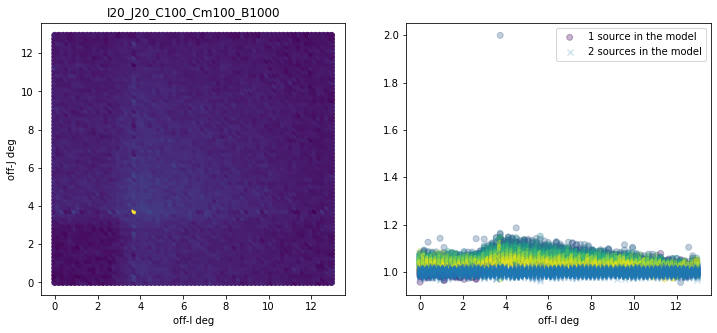

In [22]:

tag = f"I{I}_J{J}_C{C}_Cm{Cm}_B{B}"
base = "catalog-study"
os.makedirs(base, exist_ok=True)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(
    [i*deg_in_px for i, j, (b1, b2, b3, b4) in scan],
    [j*deg_in_px for i, j, (b1, b2, b3, b4) in scan],
    # [b1 for i, j, (b1, b2) in scan],
    c=[b1 for i, j, (b1, b2, b3, b4) in scan],
)

ax1.set_xlabel("off-I deg")
ax1.set_ylabel("off-J deg")

ax2.scatter(
    [i*deg_in_px for i, j, (b1, b2, b3, b4) in scan],
    # [j for i, j, (b1, b2) in scan],
    [b1 for i, j, (b1, b2, b3, b4) in scan],
    c=[j for i, j, (b1, b2, b3, b4) in scan],
    alpha=0.3,
    label="1 source in the model"
)

ax2.scatter(
    [i*deg_in_px for i, j, (b1, b2, b3, b4) in scan],
    # [j for i, j, (b1, b2) in scan],
    [b3 for i, j, (b1, b2, b3, b4) in scan],
    marker="x",
    alpha=0.2,
    label="2 sources in the model"
)

ax2.set_xlabel("off-I deg")
ax2.legend()

ax1.set_title(f"{tag}")


import json
json.dump(scan, open(f"{base}/{tag}.json", "w"))

fn_png = f"{base}/{tag}.png"
plt.savefig(fn_png)
print(fn_png)